# Libraries

In [85]:
# Data wrangling
import numpy as np
import pandas as pd

# Data visualizationpip
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Hyperparameter tuning
from skopt import BayesSearchCV

# Notebook display
from IPython.core.display import HTML

# Set output of sklearn processing to pandas DataFrame
set_config(transform_output='pandas')

## Libraries settings

In [86]:
# Configurações do sns
sns.set_theme(
    context='notebook',
    style='ticks',
    palette='colorblind',
    rc = {
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
        'legend.title_fontsize': 8,
        'legend.fontsize': 8,
        'legend.frameon': False
    }
)

# Modelling

In [87]:
# Loading processed data
df = pd.read_csv('../data/processed/telco_churn.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [88]:
# Spliting dataset in X, y, train and test
X = df.copy().drop(columns='Churn')
y = df.copy()['Churn'].map({'No': 0, 'Yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [89]:
# Preprocessing
preprocessing = ColumnTransformer([
        ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), selector(dtype_include='object')),
        ('STD', StandardScaler(), selector(dtype_include='number'))
])

In [90]:
# Empty list of pipelines
pipelines = []

## Modelling without balancing strategies

In [91]:
# Logistic Regression
lr = Pipeline([
    ('PP', preprocessing),
    ('LR', LogisticRegression(random_state=42))
])

pipelines.append(lr)

In [92]:
# Random Forest
rf = Pipeline([
    ('PP', preprocessing),
    ('RF', RandomForestClassifier(random_state=42, bootstrap=True))
])

pipelines.append(rf)

## Modelling with balancing strategies

### Logistic Regression


In [93]:
# Logistic Regression with Random Oversampling
lr_ros = Pipeline([
    ('PP', preprocessing),
    ('ROS', RandomOverSampler(random_state=42)),
    ('LR', LogisticRegression(random_state=42))
])

pipelines.append(lr_ros)

In [94]:
# Logistic Regression with SMOTE
lr_smt = Pipeline([
    ('PP', preprocessing),
    ('SMT', SMOTE(random_state=42)),
    ('LR', LogisticRegression(random_state=42))

])

pipelines.append(lr_smt)

In [95]:
# Logistic Regression with ADASYN
lr_ads = Pipeline([
    ('PP', preprocessing),
    ('ADS', ADASYN(random_state=42)),
    ('LR', LogisticRegression(random_state=42))

])

pipelines.append(lr_ads)

In [96]:
# Logistic Regression with Random Undersampling
lr_rus = Pipeline([
    ('PP', preprocessing),
    ('RUS', RandomUnderSampler(random_state=42)),
    ('LR', LogisticRegression(random_state=42))

])

pipelines.append(lr_rus)

In [97]:
# Logistic Regression with NearMiss
lr_nms = Pipeline([
    ('PP', preprocessing),
    ('NMS', NearMiss()),
    ('LR', LogisticRegression(random_state=42))
])

pipelines.append(lr_nms)

### Random Forest

In [98]:
# Random Forest with Random Oversampling
rf_ros = Pipeline([
    ('PP', preprocessing),
    ('ROS', RandomOverSampler(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42))
])

pipelines.append(rf_ros)

In [99]:
# Random Forest with SMOTE
rf_smt = Pipeline([
    ('PP', preprocessing),
    ('SMT', SMOTE(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42))
])

pipelines.append(rf_smt)

In [100]:
# Random Forest with ADASYN
rf_ads = Pipeline([
    ('PP', preprocessing),
    ('ADS', ADASYN(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42))
])

pipelines.append(rf_ads)

In [101]:
# Random Forest with Random Undersampling
rf_rus = Pipeline([
    ('PP', preprocessing),
    ('RUS', RandomUnderSampler(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42))
])

pipelines.append(rf_rus)

In [152]:
# Random Forest with Near Miss
rf_nms = Pipeline([
    ('PP', preprocessing),
    ('NMS', NearMiss()),
    ('RF', RandomForestClassifier(random_state=42))
])

pipelines.append(rf_nms)

# Evaluation

In [103]:
# Cross validation with stratified K-folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [135]:
# Compute results
results = [cross_validate(pipe, X_train, y_train, scoring='recall', cv=skf,
                          return_train_score=True, n_jobs=-1) \
           for pipe in pipelines]

In [136]:
# Summarize results
results_summ =[[res['train_score'].mean(), res['train_score'].std(),
                res['test_score'].mean(), res['test_score'].std()] \
               for res in results]

In [137]:
# Descrição da pipeline
description = [['LR', 'SEM'],
               ['RF', 'SEM'],]

for pipe in pipelines [2:]:
    description.append(list(pipe.named_steps.keys())[:-3:-1])

In [138]:
# Dataframe with results
df_res = [desc + res for desc, res in zip(description, results_summ)]

df_res = pd.DataFrame(data=df_res,
                      columns=['Model', 'Imb_strategy', 'train',
                               'train_std', 'test', 'test_std'])

df_res.style.background_gradient(cmap='Blues')

,Model,Imb_strategy,train,train_std,test,test_std
0,LR,SEM,0.552227,0.002705,0.548490,0.031916
1,RF,SEM,0.995324,0.001393,0.481403,0.045481
2,LR,ROS,0.806705,0.003958,0.798131,0.036571
3,LR,SMT,0.805278,0.007358,0.798845,0.040775
4,LR,ADS,0.850769,0.006921,0.843085,0.036780
5,LR,RUS,0.810033,0.006355,0.808835,0.038414
6,LR,NMS,0.796163,0.004467,0.798789,0.045043
7,RF,ROS,0.998890,0.001015,0.572720,0.037582
8,RF,SMT,0.997464,0.001268,0.565588,0.043911
9,RF,ADS,0.997860,0.000941,0.578414,0.041620


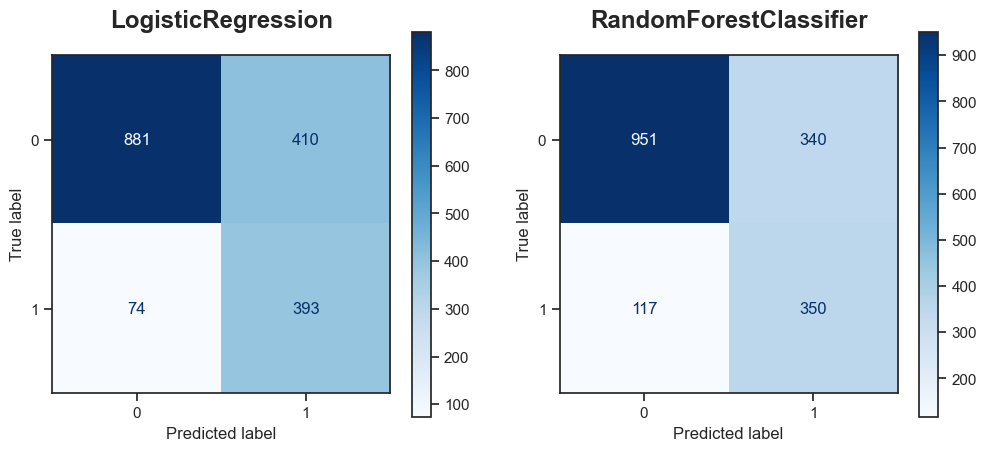

In [139]:
# Matrizes de confusão
best_lr = lr_ads
best_rf = rf_rus
best_lr.fit(X_train, y_train)
best_rf.fit(X_train, y_train)


fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
ax[0].set_title('LogisticRegression')
metrics.ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, ax=ax[0], cmap='Blues')
ax[1].set_title('RandomForestClassifier')
metrics.ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax=ax[1], cmap='Blues');

# Hyperparameter Tuning

## Logistic Regression

In [123]:
# Parameters space for Logistic Regression models
lr_param_space = {
    'LR__C': (1e-6, 1e+6, 'log-uniform'),  
    'LR__fit_intercept': [True, False],
    'LR__class_weight': [None, 'balanced'], 
    'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'LR__max_iter': (100, 1000),
    'LR__tol': (1e-6, 1e-3, 'log-uniform')
}

In [141]:
# Bayes Search for Logistic Regression
lr_tuned = BayesSearchCV(lr, lr_param_space, n_iter=50, cv=skf, scoring='recall', n_jobs=-1, random_state=42)
np.int = int  # This line avoid the following error "AttributeError: module 'numpy' has no attribute 'int'."
lr_tuned.fit(X_train, y_train)
metrics.roc_auc_score(y_test, lr_tuned.predict(X_test))

c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated

0.7218811836847752

In [146]:
metrics.roc_auc_score(y_test, lr.predict(X_test))

0.7257002439886083

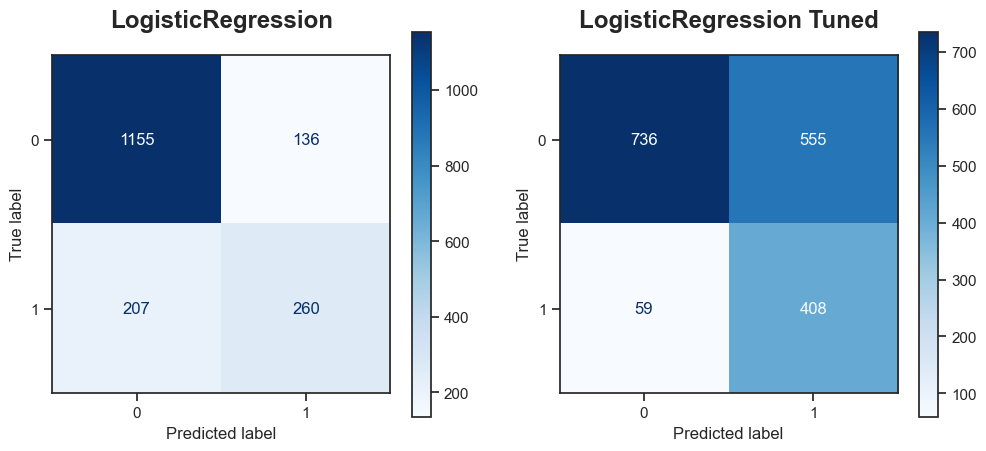

In [159]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
ax[0].set_title('LogisticRegression')
metrics.ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, ax=ax[0], cmap='Blues')
ax[1].set_title('LogisticRegression Tuned')
metrics.ConfusionMatrixDisplay.from_estimator(lr_tuned, X_test, y_test, ax=ax[1], cmap='Blues');

In [143]:
# Bayes Search for Logistic Regression with ADASYN
lr_ads_tuned = BayesSearchCV(lr_ads, lr_param_grid, n_iter=50, cv=skf, scoring='recall', n_jobs=-1, random_state=42)
lr_ads_tuned.fit(X_train, y_train)
metrics.roc_auc_score(y_test, lr_ads_tuned.predict(X_test))

c:\Users\gui_p\miniconda3\envs\telco_churn\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.7230430736925213

In [145]:
metrics.roc_auc_score(y_test, lr_ads.predict(X_test))

0.7619792435523813

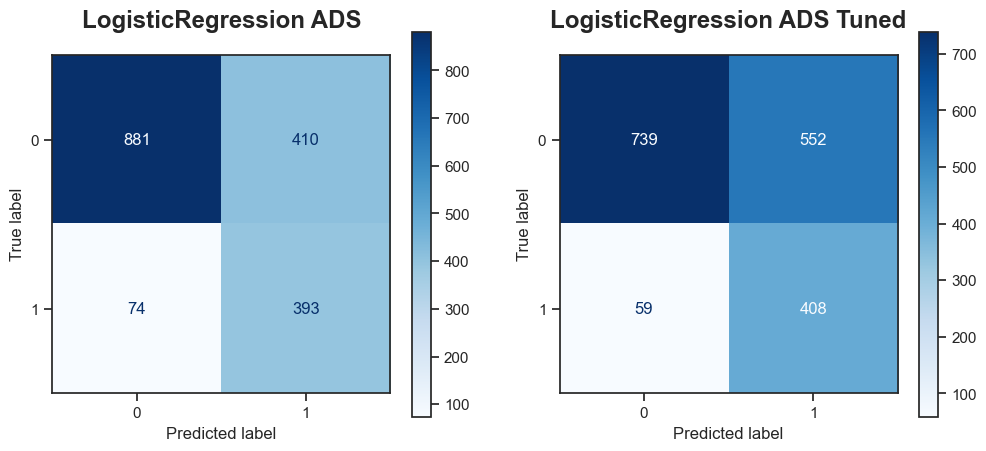

In [160]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
ax[0].set_title('LogisticRegression ADS')
metrics.ConfusionMatrixDisplay.from_estimator(lr_ads, X_test, y_test, ax=ax[0], cmap='Blues')
ax[1].set_title('LogisticRegression ADS Tuned')
metrics.ConfusionMatrixDisplay.from_estimator(lr_ads_tuned, X_test, y_test, ax=ax[1], cmap='Blues');

## Random Forest

In [147]:
# Parameters space for Random Forest models
rf_param_space = {
    'RF__n_estimators': np.arange(50, 200),
    'RF__max_features': [None, 'sqrt', 'log2'],
    'RF__max_depth': np.arange(1, 30),
    'RF__min_samples_split': np.arange(2, 10),
    'RF__min_samples_leaf': np.arange(1, 4),
    'RF__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [148]:
# Bayes Search for Random Forest
rf_tuned = BayesSearchCV(rf, rf_param_space, n_iter=50, cv=skf, scoring='recall', n_jobs=-1, random_state=42)
np.int = int  # This line avoid the following error "AttributeError: module 'numpy' has no attribute 'int'."
rf_tuned.fit(X_train, y_train)
metrics.roc_auc_score(y_test, rf_tuned.predict(X_test))

0.7495633582519071

In [151]:
rf.fit(X_train, y_train)
metrics.roc_auc_score(y_test, rf.predict(X_test))

0.6842404258107107

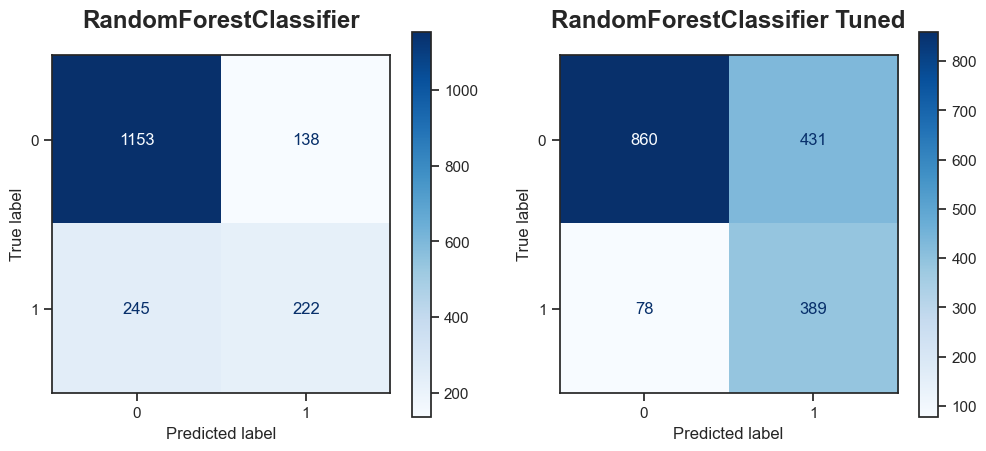

In [156]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
ax[0].set_title('RandomForestClassifier')
metrics.ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax[0], cmap='Blues')
ax[1].set_title('RandomForestClassifier Tuned')
metrics.ConfusionMatrixDisplay.from_estimator(rf_tuned, X_test, y_test, ax=ax[1], cmap='Blues');

In [153]:
# Bayes Search for Random Forest
rf_rus_tuned = BayesSearchCV(rf_rus, rf_param_space, n_iter=50, cv=skf, scoring='recall', n_jobs=-1, random_state=42)
np.int = int  # This line avoid the following error "AttributeError: module 'numpy' has no attribute 'int'."
rf_rus_tuned.fit(X_train, y_train)
metrics.roc_auc_score(y_test, rf_rus_tuned.predict(X_test))

0.7270984927773732

In [154]:
metrics.roc_auc_score(y_test, rf_rus.predict(X_test))

0.74305146650257

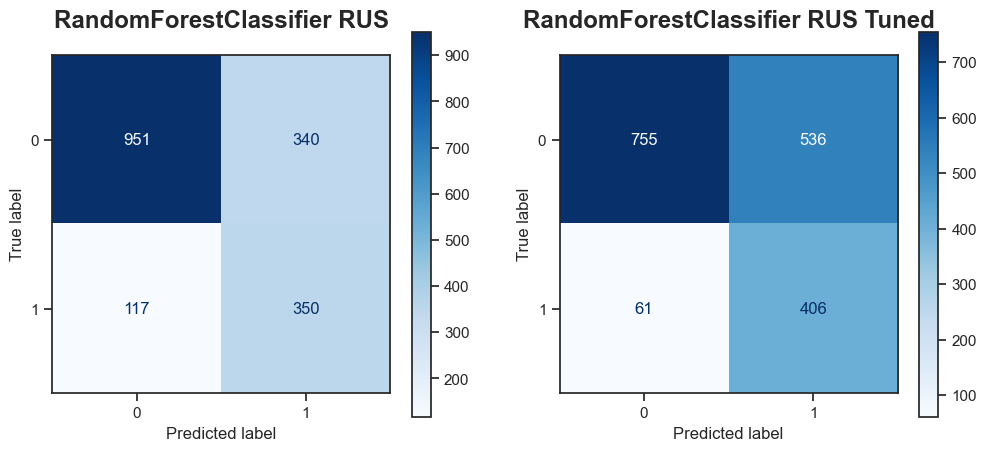

In [161]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)
ax[0].set_title('RandomForestClassifier RUS')
metrics.ConfusionMatrixDisplay.from_estimator(rf_rus, X_test, y_test, ax=ax[0], cmap='Blues')
ax[1].set_title('RandomForestClassifier RUS Tuned')
metrics.ConfusionMatrixDisplay.from_estimator(rf_rus_tuned, X_test, y_test, ax=ax[1], cmap='Blues');